# Импорты библиотек

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [4]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

## Преобразование типов

In [5]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [6]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

/tmp/ipython-input-1753512175.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)


## Склеивание дублей и индексация по user_id

In [7]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
df_cleaned.head()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-14,0,2025-05-11,0.0,16.334507,0.0


### Вспомогательные методы

In [8]:
def shapiro_check(dataset, col, alpha=0.05):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    stat, pvalue = st.shapiro(dataset[col].sample(n=3000))
    print('Шапиро')
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, 'norm', args=(mu, sigma))

    print('Колмогоров-Смирнов')

    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному р
    """
    medi = dataset[col].median()
    Q1, Q3 = dataset[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1

    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR

    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Устраняем асинхронность в датах - дата первой покупки не должна быть меньше даты логина или регистрации

In [9]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

## Убрать выбросы по межквартильному размаху

In [10]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, 'total_buy')

shapiro_check(df_cleaned_iqr, 'total_buy')
kstest_check(df_cleaned_iqr, 'total_buy')
shapiro_check(df_cleaned_iqr, 'total_return')
kstest_check(df_cleaned_iqr, 'total_return')

Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



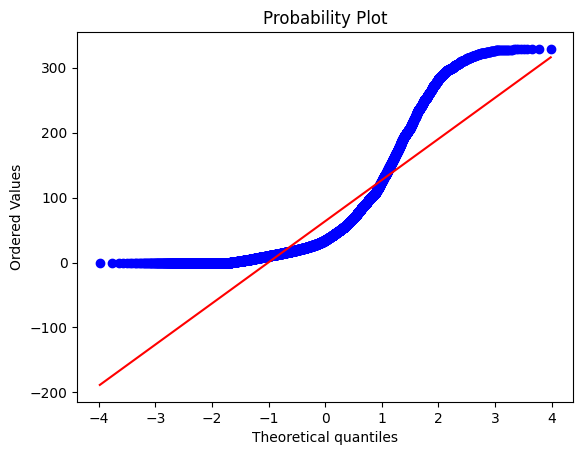

In [11]:
st.probplot(df_cleaned_iqr['total_buy'], plot=plt)

plt.show()

## Выводы

Данные распределены не нормально на уровне доверия 95%. При проверке гипотез будем использовать непараметрические тесты.

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации Саша Р.
 2. Влияние браузера на прибыльность или на скорость покупки. Саша Г.
 3. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов. Лиля
 4. Аномальные всплески покупок за весь период анализа. Антон
 5. Аномальные всплески возвратов за весь период анализа. Антон

Стратегия проверки: Формулируем каждую гипотезу в формате $H_0H_1$. В дальнейшем проверяем каждую гипотезу отдельно уровне доверия 95%.


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_   

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

###Переформулируем гипотезу в формате H₀H₁:

H₀: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, нет значимого отличия по среднему значению и дисперсиям по ключевым метрикам (количество покупок/возвратов, вероятность совершения покупки и т.д.) от пользователей с нормальной последовательностью событий (регистрация → логин → покупка).

H₁: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, есть значимое отличие по среднему значению и дисперсиям по ключевым метрикам от пользователей с нормальной последовательностью событий.

In [12]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_cleaned_iqr.copy()

df_enriched["first_buy_reg_diff"] = (
    df_cleaned_iqr["first_buy"] - df_cleaned_iqr["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_cleaned_iqr["first_login"] - df_cleaned_iqr["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_cleaned_iqr["first_login"] - df_cleaned_iqr["reg_dt"]
).dt.days
display(df_enriched.head(2))


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,first_buy_reg_diff,first_login_buy_diff,first_login_reg_diff
user_id,,,,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0,217,0,217
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0,5,-15,-10


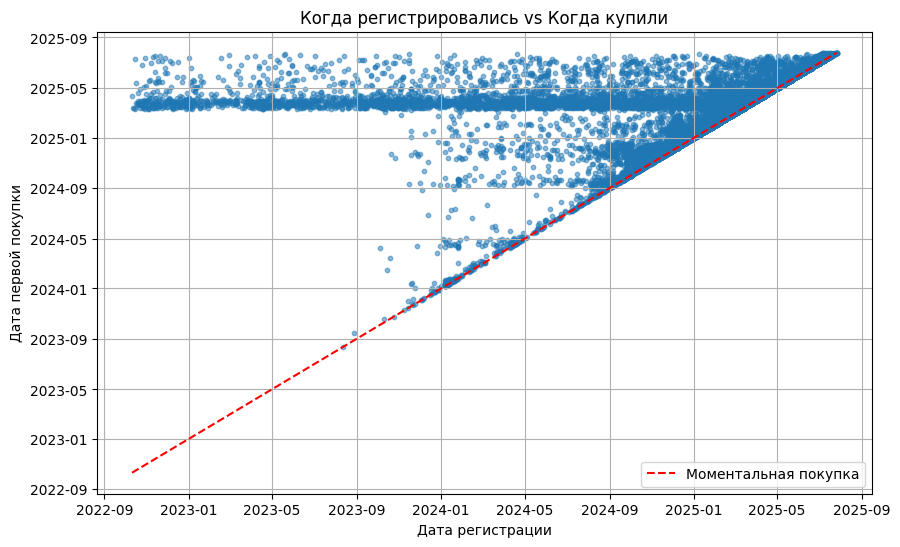

In [13]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

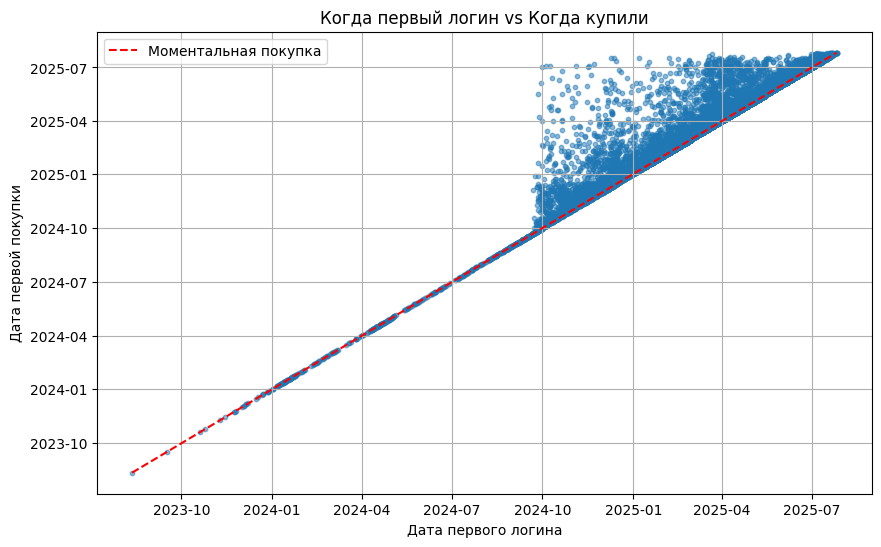

In [14]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости.

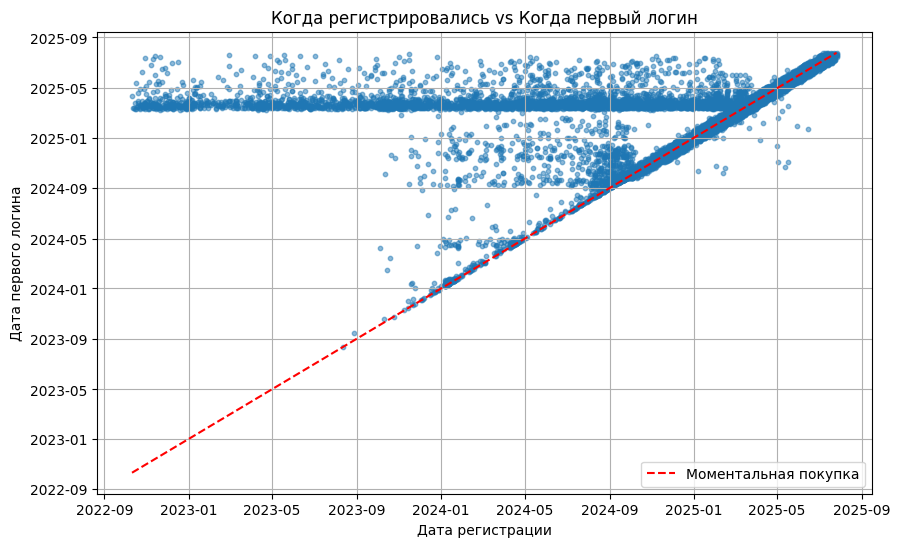

In [15]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.   
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа.

#Чек-поинт 2: Анализ Саша Р.

In [16]:
# 1. Разница между регистрацией и первым логином (дни)
df_cleaned_iqr['days_reg_to_login'] = (df_cleaned_iqr['first_login'] - df_cleaned_iqr['reg_dt']).dt.days
#df_cleaned_iqr['days_reg_to_login'] = (df_cleaned_iqr['first_buy'] - df_cleaned_iqr['first_login']).dt.days

# 2. Разница между первой покупкой и регистрацией (дни)
#    Отрицательные значения будут означать покупку ДО регистрации
df_cleaned_iqr['days_first_buy_to_reg'] = (df_cleaned_iqr['first_buy'] - df_cleaned_iqr['reg_dt']).dt.days



In [17]:
# Создадим некоторые производные метрики для анализа
df_cleaned_iqr['net_revenue'] = df_cleaned_iqr['total_buy'] - df_cleaned_iqr['total_return']
df_cleaned_iqr['has_return'] = df_cleaned_iqr['total_return'] > 0
df_cleaned_iqr['is_buyer'] = df_cleaned_iqr['first_buy'].notna()

РАСПРЕДЕЛЕНИЕ ДНЕЙ МЕЖДУ РЕГИСТРАЦИЕЙ И ПЕРВЫМ ЛОГИНОМ
count    20439.000000
mean        64.823181
std        167.816707
min       -203.000000
25%         -1.000000
50%          0.000000
75%         10.000000
max        988.000000
Name: days_reg_to_login, dtype: float64

Ключевые процентили:
0%-й процентиль: -203.0 дней
25%-й процентиль: -1.0 дней
50%-й процентиль: 0.0 дней
75%-й процентиль: 10.0 дней
90%-й процентиль: 266.0 дней
95%-й процентиль: 491.0 дней
99%-й процентиль: 807.6 дней
100%-й процентиль: 988.0 дней


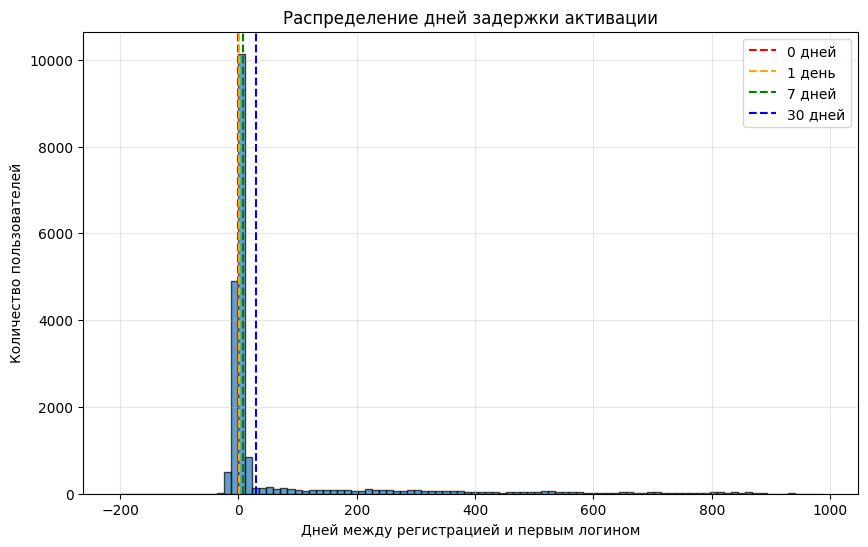

In [18]:
# Давайте проанализируем распределение
print("РАСПРЕДЕЛЕНИЕ ДНЕЙ МЕЖДУ РЕГИСТРАЦИЕЙ И ПЕРВЫМ ЛОГИНОМ")
print(df_cleaned_iqr['days_reg_to_login'].describe())

# Посмотрим на процентили
print("\nКлючевые процентили:")
percentiles = [0, 25, 50, 75, 90, 95, 99, 100]
for p in percentiles:
    value = df_cleaned_iqr['days_reg_to_login'].quantile(p/100)
    print(f"{p}%-й процентиль: {value:.1f} дней")

# Гистограмма
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned_iqr['days_reg_to_login'], bins=100, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='0 дней')
plt.axvline(x=1, color='orange', linestyle='--', label='1 день')
plt.axvline(x=7, color='green', linestyle='--', label='7 дней')
plt.axvline(x=30, color='blue', linestyle='--', label='30 дней')
plt.xlabel('Дней между регистрацией и первым логином')
plt.ylabel('Количество пользователей')
plt.title('Распределение дней задержки активации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Промежуточные результаты
- Медиана: 0 дней — половина пользователей входит в тот же день
- Среднее: 64,8 дней — сильно выше медианы из-за выбросов
- Стандартное отклонение: 167,8 дней — огромный разброс!!!

## Ключевые процентили:
- 25%: -1 день (некоторые входят за день ДО регистрации)

- 50%: 0 дней (мгновенная активация)

- 75%: 10 дней (только 25% пользователей ждут больше 10 дней)

- 90%: 266 дней (10% пользователей ждут почти год!)

- 95%: 491 дня (5% ждут более 1.3 года)

Поделим выборку на 4 сегмента:
- Мгновенные: days_reg_to_login == 0, Активация в день регистрации (25% пользователей, так как медиана = 0)
- Быстрые: 0 < days_reg_to_login ≤ 10, Активация в течение 10 дней (еще 25%, так как 75% процентиль = 10)
- Медленные: days_reg_to_login > 10, активация через более чем 10 дней (25% пользователей)

Технические аномалии (days_reg_to_login < 0,
Вход ДО регистрации (25% пользователей)) отбросим.

net_revenue - разница между total_buy и total_return

ЧИСТЫЙ АНАЛИЗ ТРЕХ ПОВЕДЕНЧЕСКИХ СЕГМЕНТОВ
Всего пользователей: 15004
Распределение по сегментам:
  Мгновенная: 5214 пользователей (34.8%)
  Медленная: 5082 пользователей (33.9%)
  Быстрая: 4708 пользователей (31.4%)

КЛЮЧЕВЫЕ МЕТРИКИ

TOTAL_BUY:
                    median   mean  count
activation_segment                      
Мгновенная           33.08  61.67   5214
Быстрая              32.01  60.79   4708
Медленная            43.59  75.15   5082

NET_REVENUE:
                    median   mean  count
activation_segment                      
Мгновенная           27.64  43.76   5214
Быстрая              27.26  42.25   4708
Медленная            34.92  45.48   5082

TOTAL_RETURN:
                    median   mean  count
activation_segment                      
Мгновенная             0.0  17.91   5214
Быстрая                0.0  18.54   4708
Медленная              0.0  29.67   5082


/tmp/ipython-input-2710389930.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_clean.groupby('activation_segment')[metric].agg(['median', 'mean', 'count'])
/tmp/ipython-input-2710389930.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df_clean.groupby('activation_segment')[metric].agg(['median', 'mean', 'count'])
/tmp/ipython-input-2710389930.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

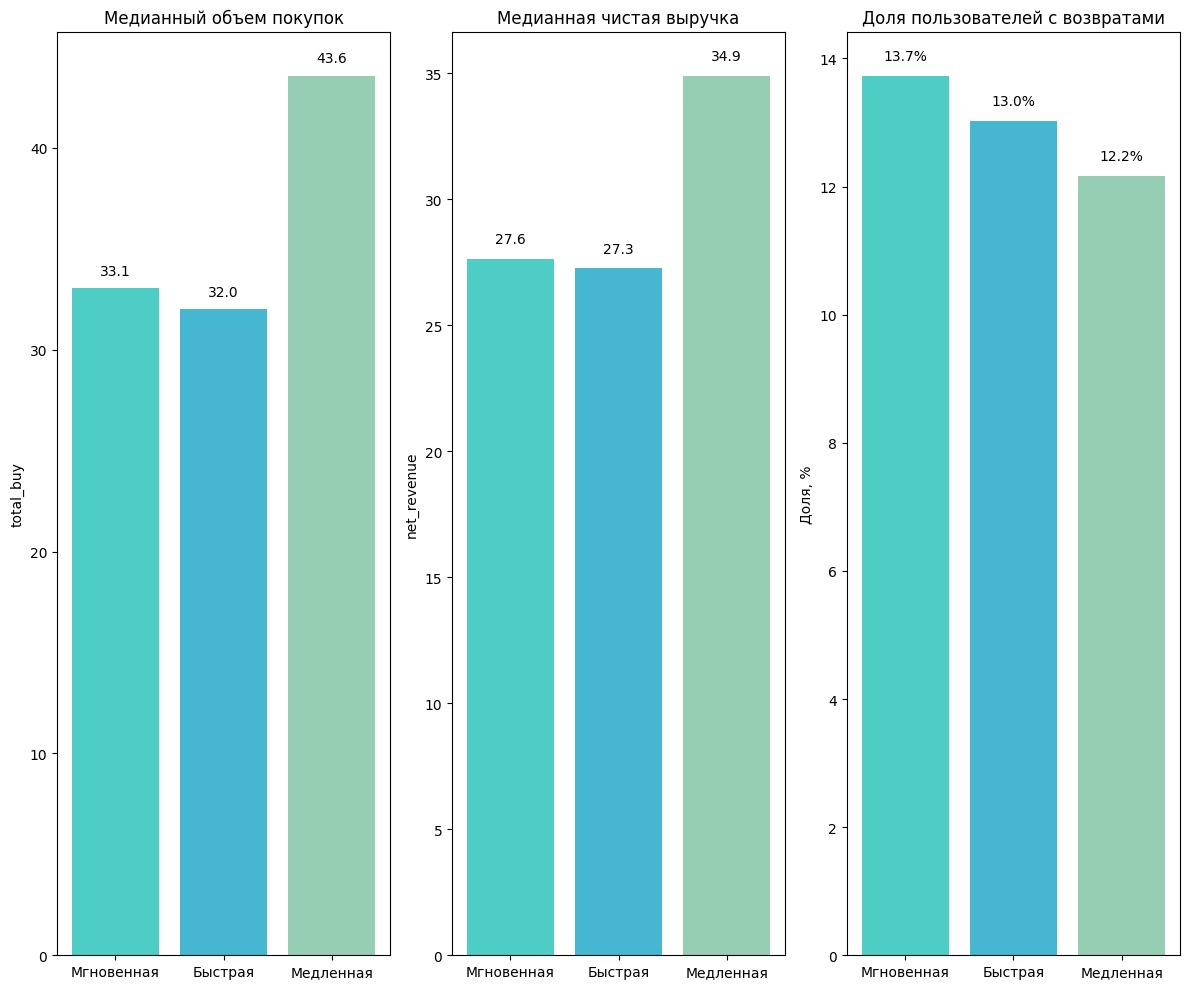


=== ПРОСТОЕ СРАВНЕНИЕ ===

total_buy:
  Мгновенная: медиана=33.08
  Медленная: медиана=43.59
  Разница: +10.51 (+31.8%)
  p-value: 0.000000
  Значимо: ДА

net_revenue:
  Мгновенная: медиана=27.64
  Медленная: медиана=34.92
  Разница: +7.28 (+26.3%)
  p-value: 0.000000
  Значимо: ДА


In [19]:
# Полностью исключаем технические аномалии с самого начала
df_clean = df_cleaned_iqr[df_cleaned_iqr['days_reg_to_login'] >= 0].copy()

# Создаем сегменты только для нормальных данных
df_clean['activation_segment'] = pd.cut(
    df_clean['days_reg_to_login'],
    bins=[-1, 0, 10, float('inf')],  # -1 для включения 0, 0-10, >10
    labels=['Мгновенная', 'Быстрая', 'Медленная']
)

print("ЧИСТЫЙ АНАЛИЗ ТРЕХ ПОВЕДЕНЧЕСКИХ СЕГМЕНТОВ")
print(f"Всего пользователей: {len(df_clean)}")
print("Распределение по сегментам:")
segment_dist = df_clean['activation_segment'].value_counts()
for segment, count in segment_dist.items():
    percentage = count / len(df_clean) * 100
    print(f"  {segment}: {count} пользователей ({percentage:.1f}%)")

# 1. Ключевые метрики по сегментам
print("\nКЛЮЧЕВЫЕ МЕТРИКИ")

metrics = ['total_buy', 'net_revenue', 'total_return']
for metric in metrics:
    print(f"\n{metric.upper()}:")
    stats = df_clean.groupby('activation_segment')[metric].agg(['median', 'mean', 'count'])
    print(stats.round(2))

# 2. Визуализация
fig, axes = plt.subplots(1, 3, figsize=(12, 10))

# График 1: Медианный total_buy
median_buy = df_clean.groupby('activation_segment')['total_buy'].median()
colors = ['#4ecdc4', '#45b7d1', '#96ceb4']
axes[0].bar(median_buy.index, median_buy.values, color=colors)
axes[0].set_title('Медианный объем покупок')
axes[0].set_ylabel('total_buy')
for i, v in enumerate(median_buy.values):
    axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

# График 2: Медианный net_revenue
median_rev = df_clean.groupby('activation_segment')['net_revenue'].median()
axes[1].bar(median_rev.index, median_rev.values, color=colors)
axes[1].set_title('Медианная чистая выручка')
axes[1].set_ylabel('net_revenue')
for i, v in enumerate(median_rev.values):
    axes[1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

# График 3: Доля с возвратами
return_rate = df_clean.groupby('activation_segment')['has_return'].mean() * 100
axes[2].bar(return_rate.index, return_rate.values, color=colors)
axes[2].set_title('Доля пользователей с возвратами')
axes[2].set_ylabel('Доля, %')
for i, v in enumerate(return_rate.values):
    axes[2].text(i, v + 0.2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Простой статистический тест
print("\n=== ПРОСТОЕ СРАВНЕНИЕ ===")
from scipy import stats

# Сравниваем Мгновенную и Медленную (самые интересные)
for metric in ['total_buy', 'net_revenue']:
    very_fast = df_clean[df_clean['activation_segment'] == 'Мгновенная'][metric]
    slow = df_clean[df_clean['activation_segment'] == 'Медленная'][metric]

    u_stat, p_value = stats.mannwhitneyu(very_fast, slow)
    diff = slow.median() - very_fast.median()
    diff_pct = (diff / very_fast.median()) * 100

    print(f"\n{metric}:")
    print(f"  Мгновенная: медиана={very_fast.median():.2f}")
    print(f"  Медленная: медиана={slow.median():.2f}")
    print(f"  Разница: {diff:+.2f} ({diff_pct:+.1f}%)")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Значимо: {'ДА' if p_value < 0.05 else 'НЕТ'}")

## Результаты
ОБЪЕМ ПОКУПОК (total_buy):

- Мгновенная: 33.08

- Быстрая: 32.01 (-3% от мгновенной)

- Медленная: 43.59 (+32% от мгновенной!!!)

ЧИСТАЯ ВЫРУЧКА (net_revenue):

- Мгновенная: 27.64

- Быстрая: 27.26 (-1% от мгновенной)

- Медленная: 34.92 (+26% от мгновенной!)

Мгновенная и быстрая очень похожи -> требуется другой подход к сегментации выборки. Поделим очищенную выборку df_clean, поделим ее на перцентили. Если соседние перцентили будут схожи, то схлопнем их вместе.

### Гипотеза №2 "Прибыльные браузеры"
_Группируем покупки по браузерам, и рассчитываем прибыль:_
```sql
(SUM(total_buy) - SUM(total_return)) / COUNT(browser)
```

###Переформулируем гипотезу в формате H₀H₁:
H₀: Прибыль не зависит от типа браузера.

H₁: Прибыль зависит от типа браузера.

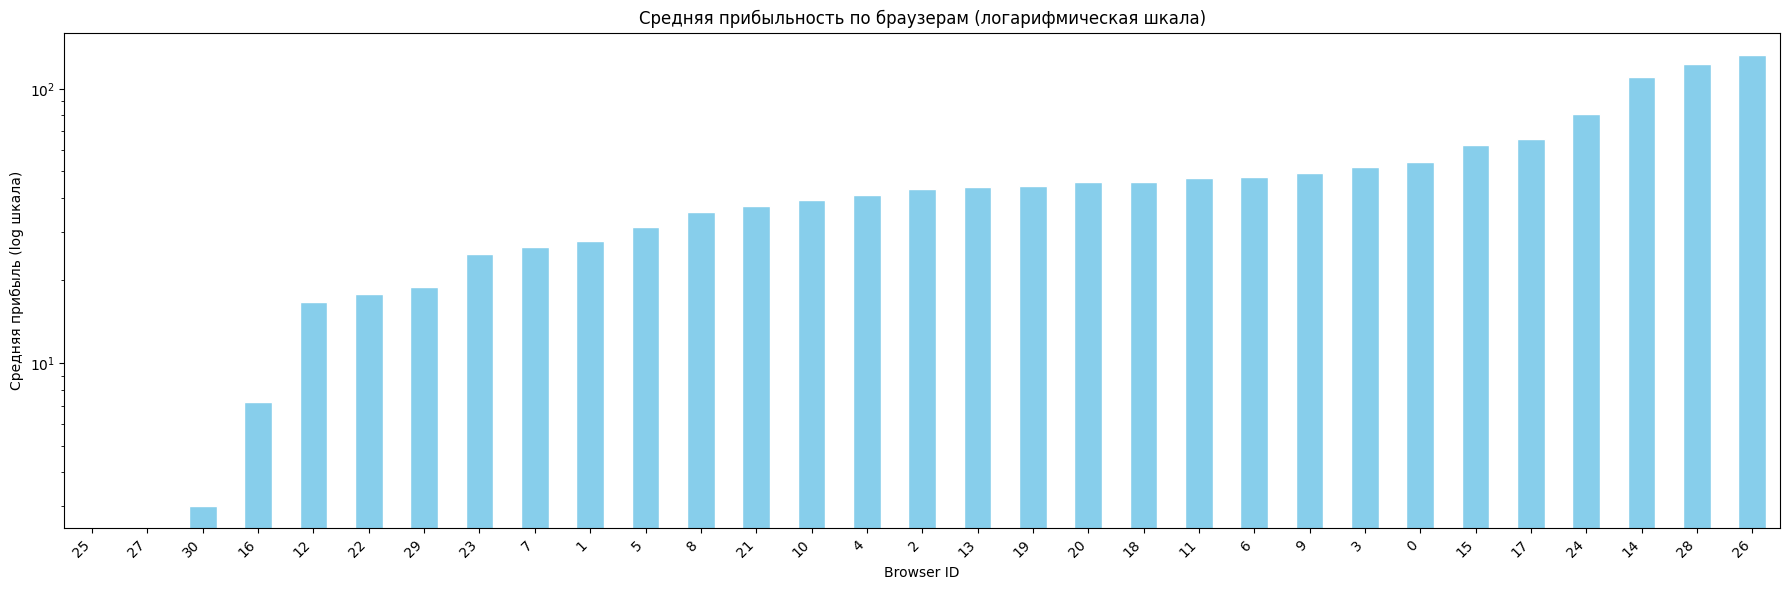

In [20]:
browser_profit = (
    df_enriched
    .groupby("browser")
    .agg(
        buy_sum=("total_buy", "sum"),
        return_sum=("total_return", "sum"),
        count=("browser", "count"),
    )
)

# Средняя прибыль на браузер
browser_profit["avg_profit"] = (browser_profit["buy_sum"] - browser_profit["return_sum"]) / browser_profit["count"]

# Сортировка по средней прибыли
browser_profit_sorted = browser_profit.sort_values("avg_profit", ascending=True)

plt.figure(figsize=(18, 6))

ax = browser_profit_sorted["avg_profit"].plot(
    kind="bar",
    color="skyblue",
    edgecolor="white",
)

plt.yscale("log")  # Логарифмическая шкала более очевидна из-за большой разницы между минимальной и максимальной прибыльностью

plt.title("Средняя прибыльность по браузерам (логарифмическая шкала)")
plt.xlabel("Browser ID")
plt.ylabel("Средняя прибыль (log шкала)")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Гипотеза №3 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

###Переформулируем гипотезу в формате H₀H₁:

H₀: Количество покупок не зависит от браузера.

H₁: Количество покупок зависит от браузера.

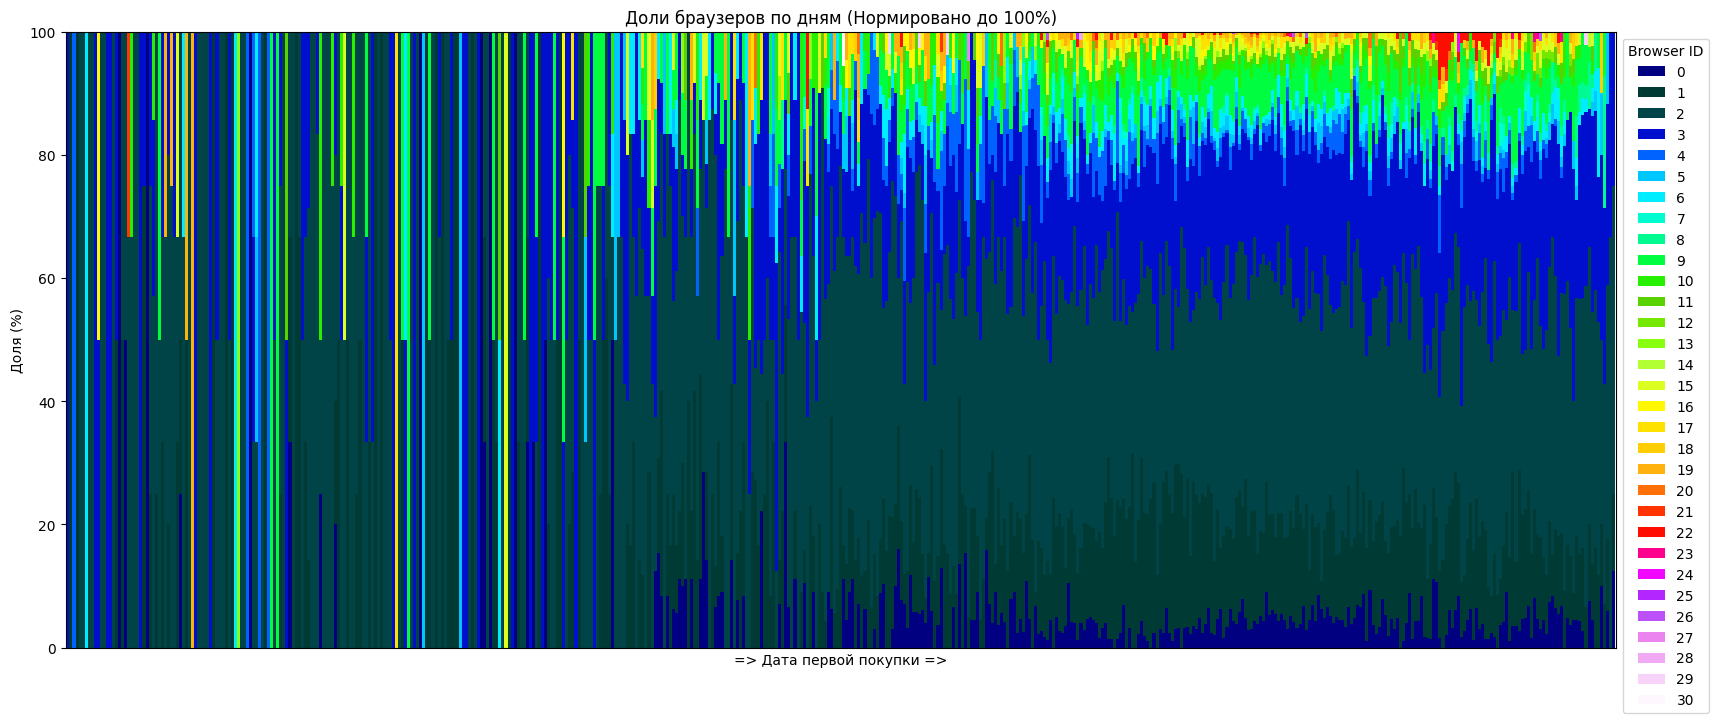

In [21]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первой покупки.

raw_counts = (
    df_enriched.groupby([df_enriched["first_buy"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первой покупки =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


Нужно дополнительно построить отдельно для пользователей с возвратами.


### Гипотеза №4 и 5 "Дружно все покупаем!", "Дружно все возвращаем!"
_Аномальные всплески покупок/возвратов за весь период анализа._  

На выдвижение данной гипотезы меня натолкнула идея построения графика покупок/возвратов относительно даты первого логина.    
Этот график не покажет реальные даты всех покупок, так как общая сумма каждого клиента будет приложена к дате его первого логина, но может показать клиентов, кто внёс большой вклад, с привязкой к данной дате.

###Переформулируем гипотезу в формате H₀H₁:
H₀: Аномальные всплески количества покупок (возвратов) за анализируемый период не коррелируют с какими-либо внешними факторами (например, с датами праздников, рекламными акциями).

H₁: Аномальные всплески количества покупок (возвратов) статистически значимо связаны с определенными внешними факторами (например, приходятся на периоды праздников или запуска маркетинговых кампаний).

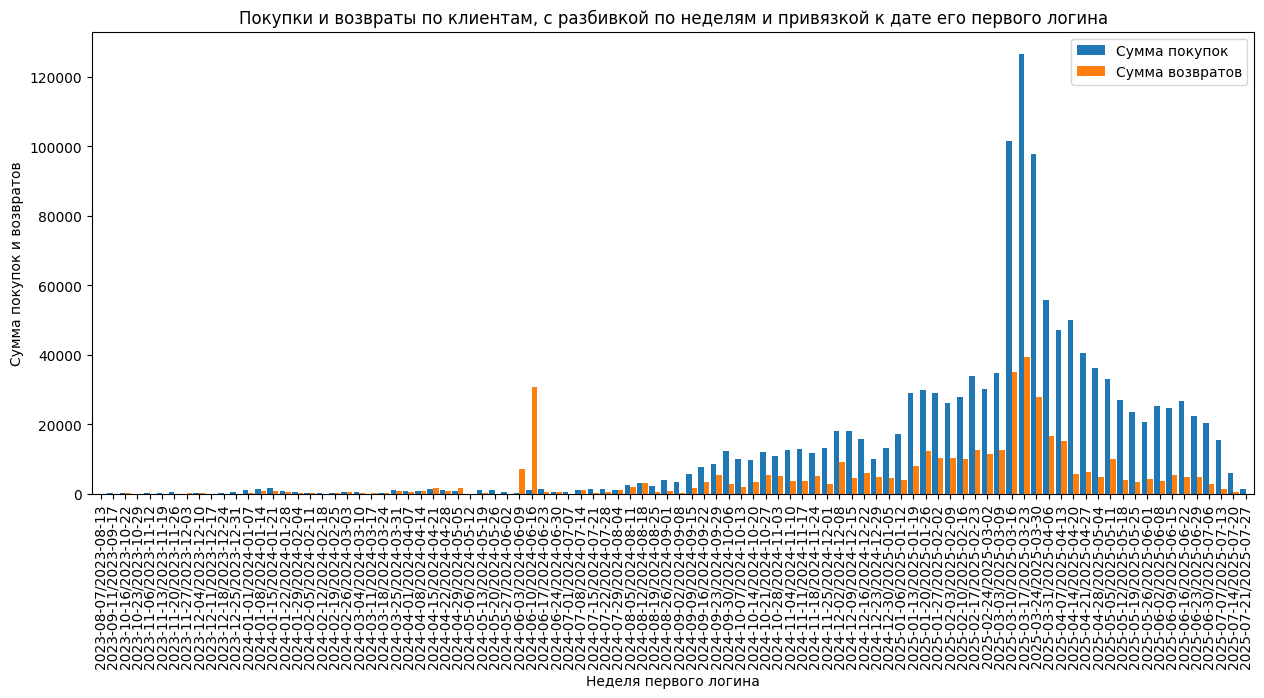

In [22]:
df_enriched["period"] = df_enriched["first_login"].dt.to_period("W")

(
    df_enriched.groupby("period")[["total_buy", "total_return"]]
    .sum()
    .plot(
        kind="bar",
        title="Покупки и возвраты по клиентам, с разбивкой по неделям и привязкой к дате его первого логина",
        figsize=(15, 6),
        width=0.9,
    )
)
plt.legend(["Сумма покупок", "Сумма возвратов"])
plt.xlabel("Неделя первого логина")
plt.ylabel("Сумма покупок и возвратов")
plt.show()


По данному графику видим аномалию в март-апреле 2025. Она коррелирует с гипотезой №1.    
Для анализа потребуется искать причины аномальной активности данных пользователей и корреляцию с гипотезой №1.